In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, getFilteredTrials, getTrials, scatter, featureExtraction, createFilterBank,
                                                label_data, psd, plot_psd,testWindowLength, testClassifier, testFrequencyBand,
                                                logvar, plot_logvar, cov, whitening, apply_mix, csp, testWindowStartTime, startRunningClassifier)


In [2]:
dataC = scipy.io.loadmat("BCICIV_1_mat/BCICIV_calib_ds1c.mat")

eeg = dataC["cnt"].T
nChannels, nSamples = eeg.shape

trainData, calibData, W_train, comp = featureExtraction(dataC,0.7)


### Base Classification

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

ldaModel = LDA()
SVMmodel = SVC()
logRegModel = LogisticRegression()


In [4]:
nCols = len(trainData.columns)

print("LDA: ",np.mean(cross_val_score(ldaModel,trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2],cv=5)))
print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2],cv=5)))
print("SVM: ",np.mean(cross_val_score(SVMmodel,trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2],cv=5)))


LDA:  0.9000000000000001
Logistic Regression:  0.9000000000000001
SVM:  0.9142857142857144


In [5]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#  Set the parameter grid for grid search
param_grid = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': np.arange(0,1,0.1)}

# Create the grid search object
gridLDA = GridSearchCV(estimator=LDA(), param_grid=param_grid,scoring="accuracy", cv=5)

# Fit the grid search to the data
gridLDA.fit(trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2])

# Get the best hyperparameters
print(gridLDA.best_params_)

# Get the best score
print(gridLDA.best_score_)



{'shrinkage': 0.0, 'solver': 'lsqr'}
0.9000000000000001


In [6]:
#Set the parameter grid for grid search
param_grid = {'penalty': ['l1','l2'], 'C':list(np.logspace(-3,3)), 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

# Create the grid search object
gridLogReg = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid,scoring='accuracy', cv=5)

# Fit the grid search to the data
gridLogReg.fit(trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2])

# Get the best hyperparameters
print(gridLogReg.best_params_)

# Get the best score
print(gridLogReg.best_score_)


{'C': 0.0071968567300115215, 'penalty': 'l2', 'solver': 'liblinear'}
0.9214285714285715


In [7]:
#Set the parameter grid for grid search

param_grid = {'C': [0.0001,0.001,0.01,1,10,100,1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':["rbf","linear"]}

# Create the grid search object
gridSVM = GridSearchCV(estimator=SVC(), param_grid=param_grid,scoring="accuracy", cv=5)

# Fit the grid search to the data
gridSVM.fit(trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2])

# Get the best hyperparameters
print(gridSVM.best_params_)

# Get the best score
print(gridSVM.best_score_)


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.9142857142857144


### Window Length Test

#### Accuracy

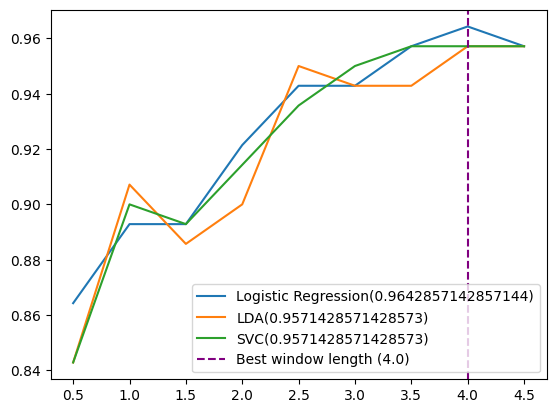

In [8]:
_ = testWindowLength(dataC,
                ["Logistic Regression","LDA","SVC"],
                "accuracy",
                0.7)

### Window Start time test

#### Accuracy

0.9


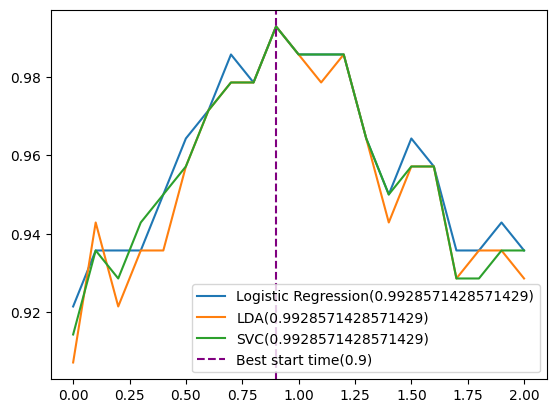

In [9]:
bestEstimator_start_time = testWindowStartTime(dataC,
                    ["Logistic Regression","LDA","SVC"],
                    "accuracy",
                    0.7,
                    4.0)


In [10]:
bestEstimator_start_time


LogisticRegression(C=0.21209508879201905, penalty='l1', solver='liblinear')

### Investigating the effect of varying the frquency band 

In [6]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataC,nSamples)

filterBank = createFilterBank(sRate)

bestBand, bestEstimator_freq_band, (best_b, best_a) = testFrequencyBand(dataC,["Logistic Regression","LDA","SVC"],filterBank,0.7,trialWinStart=0.9,trialWinEnd=4.9)
bestBand


8-12 : 0.9928571428571429
8-15 : 0.9928571428571429
13-30 : 0.8357142857142856


(8, 12)

In [12]:
np.mean(cross_val_score(bestEstimator_freq_band,calibData.iloc[:,:nCols-2], calibData.iloc[:,nCols-2],cv=5))


0.9166666666666666

### Person's Correlation Coefficient (PCC) + CSP

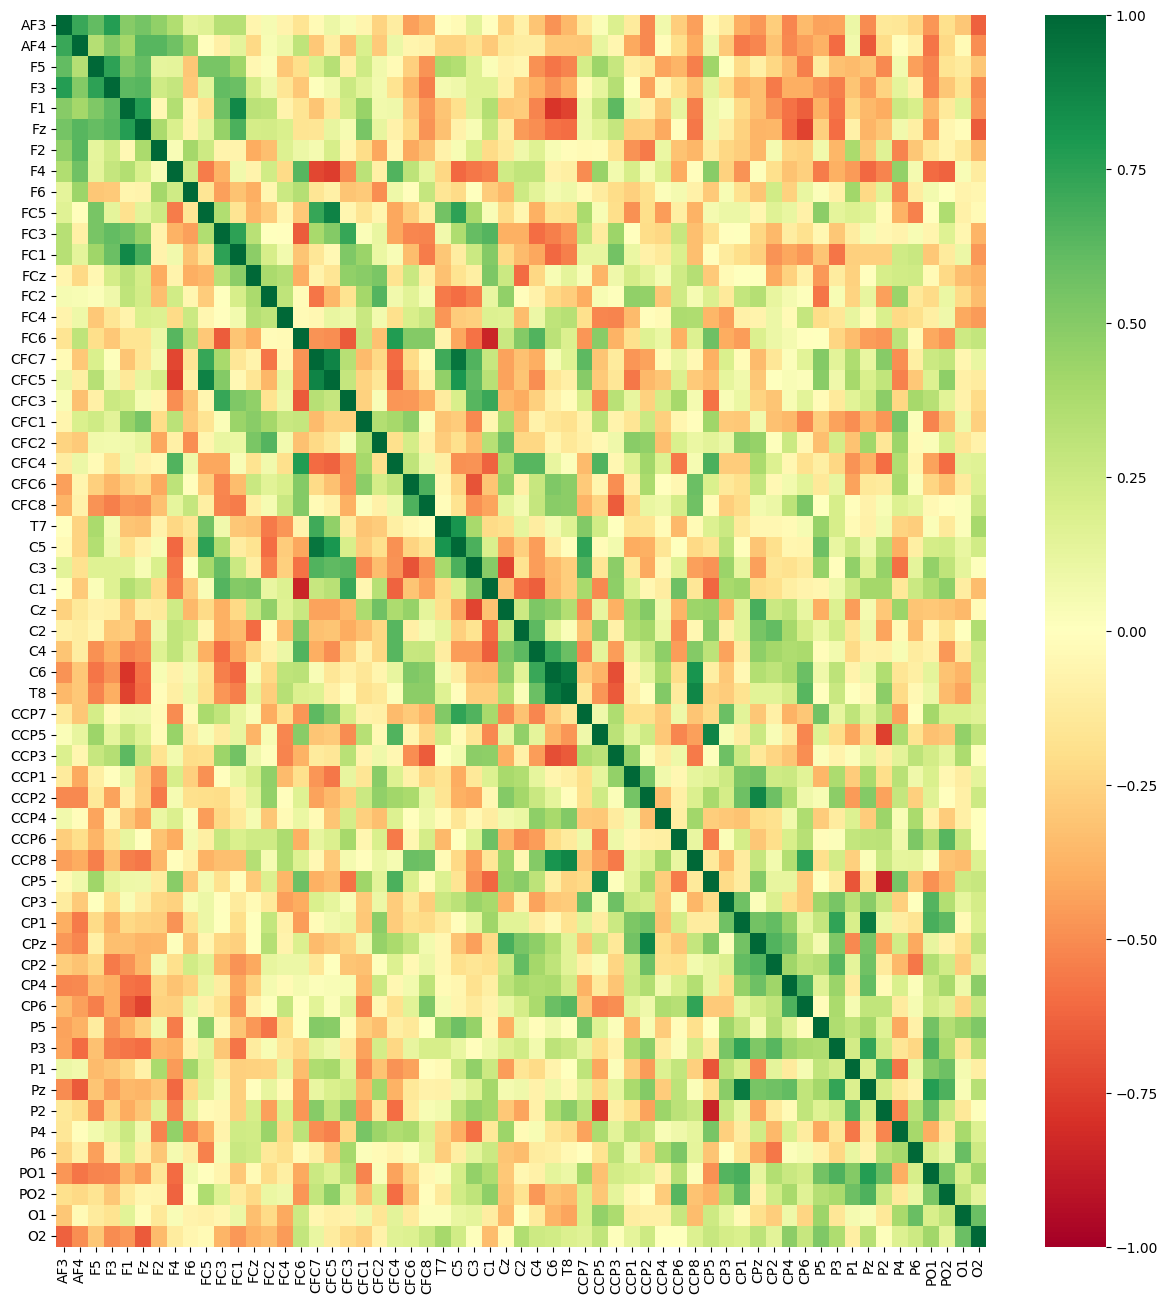

In [10]:
#Plot distributions of channels against eachother
# to find out if there is any sort of positive correlation
# between channels

trialWin = np.arange(int(0.9*sRate),int(4.9*sRate))

# #get mixed trial data from original
trials_mixed = np.zeros(
            (nChannels, len(eventOnsets[0]), len(trialWin)))


for i, onset in enumerate(eventOnsets[0]):
    trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# we can able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.

from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

scaler = StandardScaler()

# For each trial
#We must standardize the values in each trial window for each channel (We use z-score normalization for this) 
_, nTrials, _ = trials_mixed.shape

trialChannelCorrelations = []

plotFirst = False #flag to check that heatmap of first trial is plotted 

for trial in range(nTrials):
 
    zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
    corrMat = np.corrcoef(zTrial)

    if not plotFirst:
        plt.figure(figsize=(15, 16))
        sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
        plotFirst = True
    
#     # We must then calculate the correlation matrices for each trial and return the mean for each row giving, us a vector of mean values
#     # which represents the average corellation values for a specific channel in relation to other channels.
    channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

#     #Following the above referenced paper, we select the first 14 channels

    channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
    trialChannelCorrelations.append(channelCorrValues)

<AxesSubplot: >

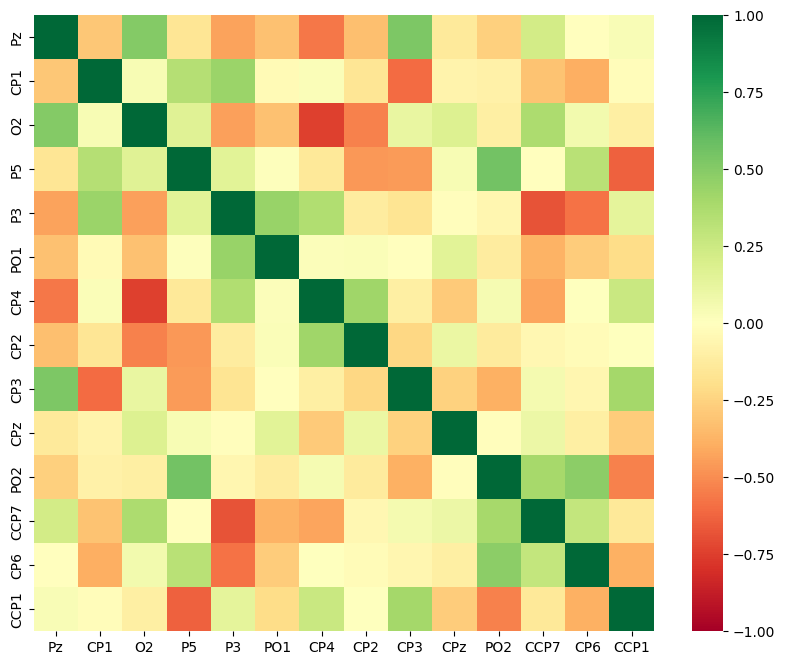

In [11]:
from collections import defaultdict

channelOccurences = defaultdict(int)

for dic in trialChannelCorrelations:
    for ch, _ in dic.items():
        channelOccurences[ch] += 1


channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

selectedChannels = list(channelOccurences.keys())[:14]
# #It can be seen that all selected channels are in and around the sensorimotor cortex

selectedSet = set(selectedChannels)
selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

# #Plot heatmap of first trial
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
            columns=selectedChannels,
            index=selectedChannels),
            cmap="RdYlGn",
            vmin=-1,
            vmax=1)




In [15]:
accVal = 0
bestAccVal = 0
bestEstimator_selected_channels = None
for model in ["Logistic Regression","LDA","SVC"]:
    accVal, estimator =  testClassifier(dataC,0.9,4.9,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)
    print(f"acc val for {model} is {accVal}")
    if accVal > bestAccVal:
        bestAccVal = accVal
        bestEstimator_selected_channels = estimator

bestAccVal


acc val for Logistic Regression is 0.8285714285714285
acc val for LDA is 0.8142857142857143
acc val for SVC is 0.8285714285714285


0.8285714285714285

In [16]:
bestEstimator_selected_channels

LogisticRegression(C=0.28117686979742307, solver='liblinear')

In [17]:
np.mean(cross_val_score(bestEstimator_selected_channels,calibData.iloc[:,:nCols-2], calibData.iloc[:,nCols-2],cv=5))

0.9166666666666666

### Calibration of best classifier to predict probability outputs for all time samples

In [7]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_estimator = CalibratedClassifierCV(bestEstimator_freq_band, cv="prefit")
calibrated_estimator.fit(calibData.iloc[:,:nCols-2], calibData.iloc[:,nCols-2])

evalDataC = scipy.io.loadmat("BCICIV_1_mat/BCICIV_eval_ds1c.mat")

probabilities = startRunningClassifier(evalDataC,calibrated_estimator,comp,W_train,trialWinStart=0.9,trialWinEnd=4.9,b=best_b,a=best_a)


In [8]:
import csv

with open("output_subject_c.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)


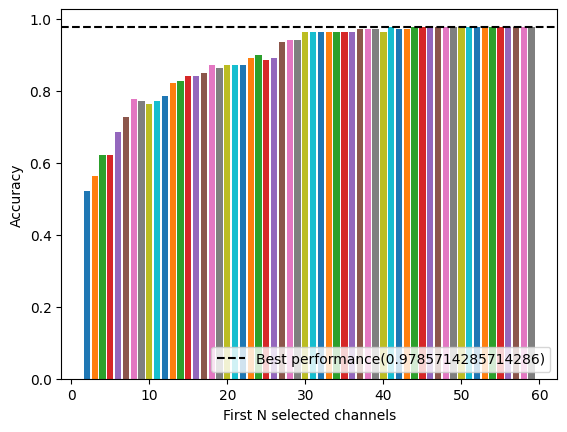

In [12]:

channelNums = dict()

for i in range(2,nChannels+1):
    selectedChannels = list(channelOccurences.keys())[:i]
    # #It can be seen that all selected channels are in and around the sensorimotor cortex

    selectedSet = set(selectedChannels)
    selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

    accVal = 0
    bestAccVal = 0
    bestEstimator_selected_channels = None
    for model in ["Logistic Regression","LDA","SVC"]:
        accVal, estimator =  testClassifier(dataC,0.9,4.9,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)

        if accVal > bestAccVal:
            bestAccVal = accVal
            bestEstimator_selected_channels = estimator

    channelNums[i] = bestAccVal

bestY = 0
for x, y in channelNums.items():
    bestY= max(bestY,y)
    plt.bar(x,y)

plt.xlabel("First N selected channels")
plt.ylabel("Accuracy")
plt.axhline(y=bestY, color='black', ls='--', lw=1.5, label=f"Best performance({bestY})")
plt.legend(loc='lower right')
